In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [70]:
(X_train, y_train), (X_test, y_test) = tf_keras.datasets.cifar10.load_data()

In [71]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

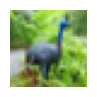

In [72]:
plt.figure(figsize=(1, 1))
plt.imshow(X_train[6])
plt.axis('off')
plt.show()

In [73]:
y_train.shape

(50000, 1)

In [74]:
# 생성 모델 학습 데이터 준비

print( np.unique(y_train) )

X_train_dog = X_train[y_train.flatten() == 5] # 개 이미지만 뽑기

# X_train_dog.max() # 255
X_train_dog_scaled = X_train_dog / X_train_dog.max()
X_train_dog_scaled = X_train_dog_scaled.astype('float32')

X_train_dog_scaled.dtype
X_train_dog.shape

[0 1 2 3 4 5 6 7 8 9]


(5000, 32, 32, 3)

In [75]:
# parameter 설정
width = 32
height = 32
channels = 3
latent_dim = 32 # 이미지 생성을 위해 초기 데이터를 추출하는 데이터 공간

In [76]:
# 판별 모델 구조 설계

# discriminator = tf_keras.models.Sequential([
#     tf_keras.layers.Input(shape=(width, height, channels)),
#     tf_keras.layers.Conv2D(filters=32, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Conv2D(filters=64, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Conv2D(filters=64, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Flatten(),
#     tf_keras.layers.Dense(1, activation="sigmoid")
# ])

d_input = tf_keras.layers.Input(shape=(width, height, channels))
d_x = tf_keras.layers.Conv2D(filters=32, kernel_size=3)(d_input)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Conv2D(filters=64, kernel_size=3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Conv2D(filters=64, kernel_size=3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Flatten()(d_x)
d_output = tf_keras.layers.Dense(1, activation="sigmoid")(d_x)

discriminator = tf_keras.models.Model(d_input, d_output)

discriminator.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 26, 26, 64)        0   

In [77]:
# 판별 모델 학습 설계

discriminator.compile(loss="binary_crossentropy", 
                      optimizer=tf_keras.optimizers.legacy.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8),
                      metrics=['accuracy'])

c:\Users\human\.conda\envs\human-dl-env2\lib\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [78]:
# 생성 모델 구조 설계

g_input = tf_keras.layers.Input(shape=(latent_dim,))
g_x = tf_keras.layers.Dense(units=128*16*16)(g_input)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Reshape(target_shape=(16, 16, 128))(g_x)

g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

# Conv2DTranspose : 이미지 확대 ( padding=='same'인 경우 width*stride, height*stride )
g_x = tf_keras.layers.Conv2DTranspose(filters=256, kernel_size=4, 
                                      strides=2, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_output = tf_keras.layers.Conv2D(filters=channels, kernel_size=5, 
                                  activation="sigmoid", padding="same")(g_x)

generator = tf_keras.models.Model(g_input, g_output)

generator.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_11 (Dense)            (None, 32768)             1081344   
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_5 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 256)       104

In [79]:
# 전체 모델 구조 설계

# 다른 모델에 포함되면 가중치 업데이트 수행 X, 단독 학습인 경우에는 가중치 업데이트 수행 O
discriminator.trainable = False 

gen_input = tf_keras.layers.Input(shape=(latent_dim))
gen_x = generator(gen_input)
gen_output = discriminator(gen_x) # 가중치 업데이트 X

gan_model = tf_keras.models.Model(gen_input, gen_output)

# gan_model.compile(loss="binary_crossentropy", optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001))
gan_model.compile(loss="binary_crossentropy", optimizer=tf_keras.optimizers.legacy.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8))

gan_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32)]              0         
                                                                 
 model_10 (Functional)       (None, 32, 32, 3)         4771587   
                                                                 
 model_9 (Functional)        (None, 1)                 99585     
                                                                 
Total params: 4871172 (18.58 MB)
Trainable params: 4771587 (18.20 MB)
Non-trainable params: 99585 (389.00 KB)
_________________________________________________________________


In [80]:
import os

image_path = "generated-images"
if not os.path.exists(image_path):  # 이 경로가 없으면
    os.mkdir(image_path)            # 만들기

iterations = 1000
batch_size = 32

start = 0 # batch 시작 위치
for step in range(iterations): # 1000번 반복
    # 잠재 공간에서 이미지로 생성할 초기 난수 발생 (32개 이미지 생성)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors) # 이미지 생성
    # print(generated_images.shape) # (32, 32, 32, 3)

    real_images = X_train_dog_scaled[start:start + batch_size]
    combined_images = np.concatenate([real_images, generated_images]) # 진짜이미지와 가짜이미지 병합
    # 진짜 이미지 : 1, 가짜 이미지 : 0
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += np.random.random(labels.shape) * 0.05 # 학습의 효율성을 높이는 구현

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors2 = np.random.normal(size=(batch_size, latent_dim))
    labels2 = np.ones((batch_size, 1))

    g_loss = gan_model.train_on_batch(random_latent_vectors2, labels2)

    start += batch_size
    if start > X_train_dog_scaled.shape[0] - batch_size: # 남은 이미지가 batch_size보다 작으면
        start = 0

    if (step > 0 and step % 50 == 0): # 50번 마다 한 번씩 이미지 저장
        print(f"{step}에서 손실 -> [ 생성기 : {g_loss}, 판별기 : {d_loss} ]")
        img = tf_keras.preprocessing.image.array_to_img(generated_images[0]*255, scale=False)
        img.save(os.path.join(image_path, f'generated-image-{step}.png'))
        img = tf_keras.preprocessing.image.array_to_img(real_images[0]*255, scale=False)
        img.save(os.path.join(image_path, f'real-image-{step}.png'))


1/1 [==============================] - 1s 609ms/step
50에서 손실 -> [ 생성기 : 0.8575997948646545, 판별기 : [1.2218329906463623, 0.0] ]
1/1 [==============================] - 1s 638ms/step
100에서 손실 -> [ 생성기 : 4.006746292114258, 판별기 : [1.1417169570922852, 0.0] ]
1/1 [==============================] - 1s 649ms/step
150에서 손실 -> [ 생성기 : 3.599684715270996, 판별기 : [1.2671709060668945, 0.0] ]
1/1 [==============================] - 1s 655ms/step
200에서 손실 -> [ 생성기 : 0.8925161957740784, 판별기 : [0.723775327205658, 0.0] ]
1/1 [==============================] - 1s 619ms/step
250에서 손실 -> [ 생성기 : 0.7124109268188477, 판별기 : [0.6986773014068604, 0.0] ]
1/1 [==============================] - 1s 600ms/step
300에서 손실 -> [ 생성기 : 0.7791531682014465, 판별기 : [0.7410750389099121, 0.0] ]
1/1 [==============================] - 1s 708ms/step
350에서 손실 -> [ 생성기 : 0.6686927676200867, 판별기 : [0.6976585388183594, 0.0] ]
1/1 [==============================] - 1s 641ms/step
400에서 손실 -> [ 생성기 : 0.6206305623054504, 판별기 : [0.6955180764198